In [60]:
package SyringeSystem {
    import ISQ::*;
    import time::*;
    import SI::*;
    package Library{
        import Ports::*;
        import ExternalSystems::*;
        import PartDefs::*;
        import Actors::*;
        import ActionDefs::*;
        package Ports {
            item def Fluid;
            port def Hand {
                inout force;
            }
            port def ExtLuer{
                inout item fluid:Fluid;
            }
            port def PierceSite{
                inout item fluid:Fluid;
            }
            port def Cannula{
                inout item fluid:Fluid;
            }
            interface def PiercingInterface{
                flow of Fluid
                    from pierceSite.fluid to cannula.fluid;
                flow of Fluid
                    from cannula.fluid to pierceSite.fluid;
                end pierceSite : PierceSite;
                end cannula: Cannula;
            }
            interface def LuerInterface{
                flow of Fluid
                    from ExtPort.fluid to IntPort.fluid;
                flow of Fluid
                    from IntPort.fluid to ExtPort.fluid;
                end ExtPort : ExtLuer;
                end IntPort: ~ExtLuer;
            }
        }
        package ExternalSystems{
            item def Vial{
                port septum{
                    inout fluid:Fluid;
                }
                item drug:Fluid;
            }
            item def SharpsBin;
            item def Storage;
            item def Needle{
                port Luer: ~ExtLuer;
                port Cannula{
                    inout fluid:Fluid;
                }
            }
            item def Environment{
                port air : PierceSite;
            }
        }
        package PartDefs{
            part def Syringe{
                port Handle;
                port NeedleAttachment : ExtLuer;
                
            }
        }
        package ActionDefs{
            action TreatPatient {
                action UnpackageSyringe{}
                then event occurrence Unpackaged;
                then action AssembleNeedle{}
                then event occurrence NeedleAttached;
                then action FillDrug{}
                then event occurrence SyringeFilled;
                then action InsertCannula{}
                then event occurrence CannulaInserted;
                then action DeliverDrug{}
                then event occurrence SyringeEmptied;
                then event occurrence PatientTreated;
            }
        }
        package Actors{
            part def Human;
            part def HCP :> Human{
                port hand[2];
            }
            part def Patient :> Human{
                port injectionSite : PierceSite;
            }
        }
    }
    package Structure{
        import Library::*;
        part def Syringe1 :> Syringe{
            part plunger{
                port 'Seal Mount';
                port 'Thumb Pad';
            }
            part barrel{
                port 'Finger Pad';
                port 'Internal Bore';
                port 'Needle Attachment': ExtLuer;
            }
            part 'plunger seal'{
                port 'Plunger Surface';
                port 'Sealing Surface';
            }
            bind barrel.'Needle Attachment' = NeedleAttachment;
            bind barrel.'Finger Pad' = Handle;
            bind plunger.'Thumb Pad' = Handle;
            connect plunger.'Seal Mount' to 'plunger seal'.'Plunger Surface';
            connect barrel.'Internal Bore' to 'plunger seal'.'Sealing Surface';
        }
    }
    package Behaviour{
        import Library::*;
        attribute def unpackaging;
        attribute def filling;
        state def SyringeStates{
            entry; then state Packaged;
            port syringeHandle;
            state InUse{
                entry; 
                then state empty;
                state filled;
                transition
                    first empty
                    accept filling via syringeHandle
                    then filled;
                exit;
            }
            state Disposed;
            transition
                first Packaged
                accept after 730 [day]
                then Disposed;
            transition
                first Packaged
                accept unpackaging
                then InUse;
        }
    }
    package TreatmentContext{
        part TreatmentContext{
            perform TreatPatient;
            import Library::*;
            import Structure::*;
            part environment:Environment;
            part syringe: Syringe1{
                event TreatPatient.Unpackaged;
                event TreatPatient.NeedleAttached;
                event TreatPatient.SyringeFilled;
                event TreatPatient.SyringeEmptied;
            }
            timeslice storage = start;
            then timeslice inUse{
                connect hcp.hand to syringe.Handle;
                interface : LuerInterface connect
                    ExtPort ::> syringe.NeedleAttachment to 
                    IntPort ::> needle.Luer;
                interface cannulaConn : PiercingInterface connect
                    cannula ::>needle.Cannula to 
                    pierceSite ::> environment.air;
                part vial:Vial;
                part needle:Needle;
                part hcp: HCP{
                    perform TreatPatient.AssembleNeedle;
                    perform TreatPatient.FillDrug;
                    perform TreatPatient.InsertCannula;
                    perform TreatPatient.DeliverDrug;
                }
                part patient:Patient{
                    event TreatPatient.CannulaInserted;
                    event TreatPatient.PatientTreated;
                }
                timeslice filling = start{
                    interface redefines cannulaConn connect
                        cannula ::>needle.Cannula to 
                        pierceSite ::> vial.septum;
                }
                then timeslice delivery{
                    interface redefines cannulaConn connect
                        cannula ::>needle.Cannula to 
                        pierceSite ::> patient.injectionSite;
                }
            }
            then timeslice disposed = done{
                part sharpsBin : SharpsBin;
            }
        }
    }
    package ViewDefs{
        import Views::*;
        import TreatmentContext::*;
        view TreatmentContextView {
            expose TreatmentContext::inUse::**[@SysML::PartUsage and not (@SysML::EventOccurrenceUsage)];
            render asInterconnectionDiagram;
        }
    }
}

Package SyringeSystem (c0ee6576-76f3-4429-9a43-98293c4a063c)


In [3]:
%viz --view=action "SyringeSystem::TreatmentContext::TreatmentContext::syringe"

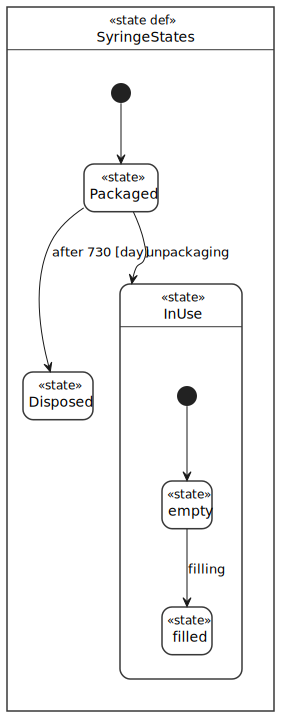

In [61]:
%viz --view=state "SyringeSystem::Behaviour"

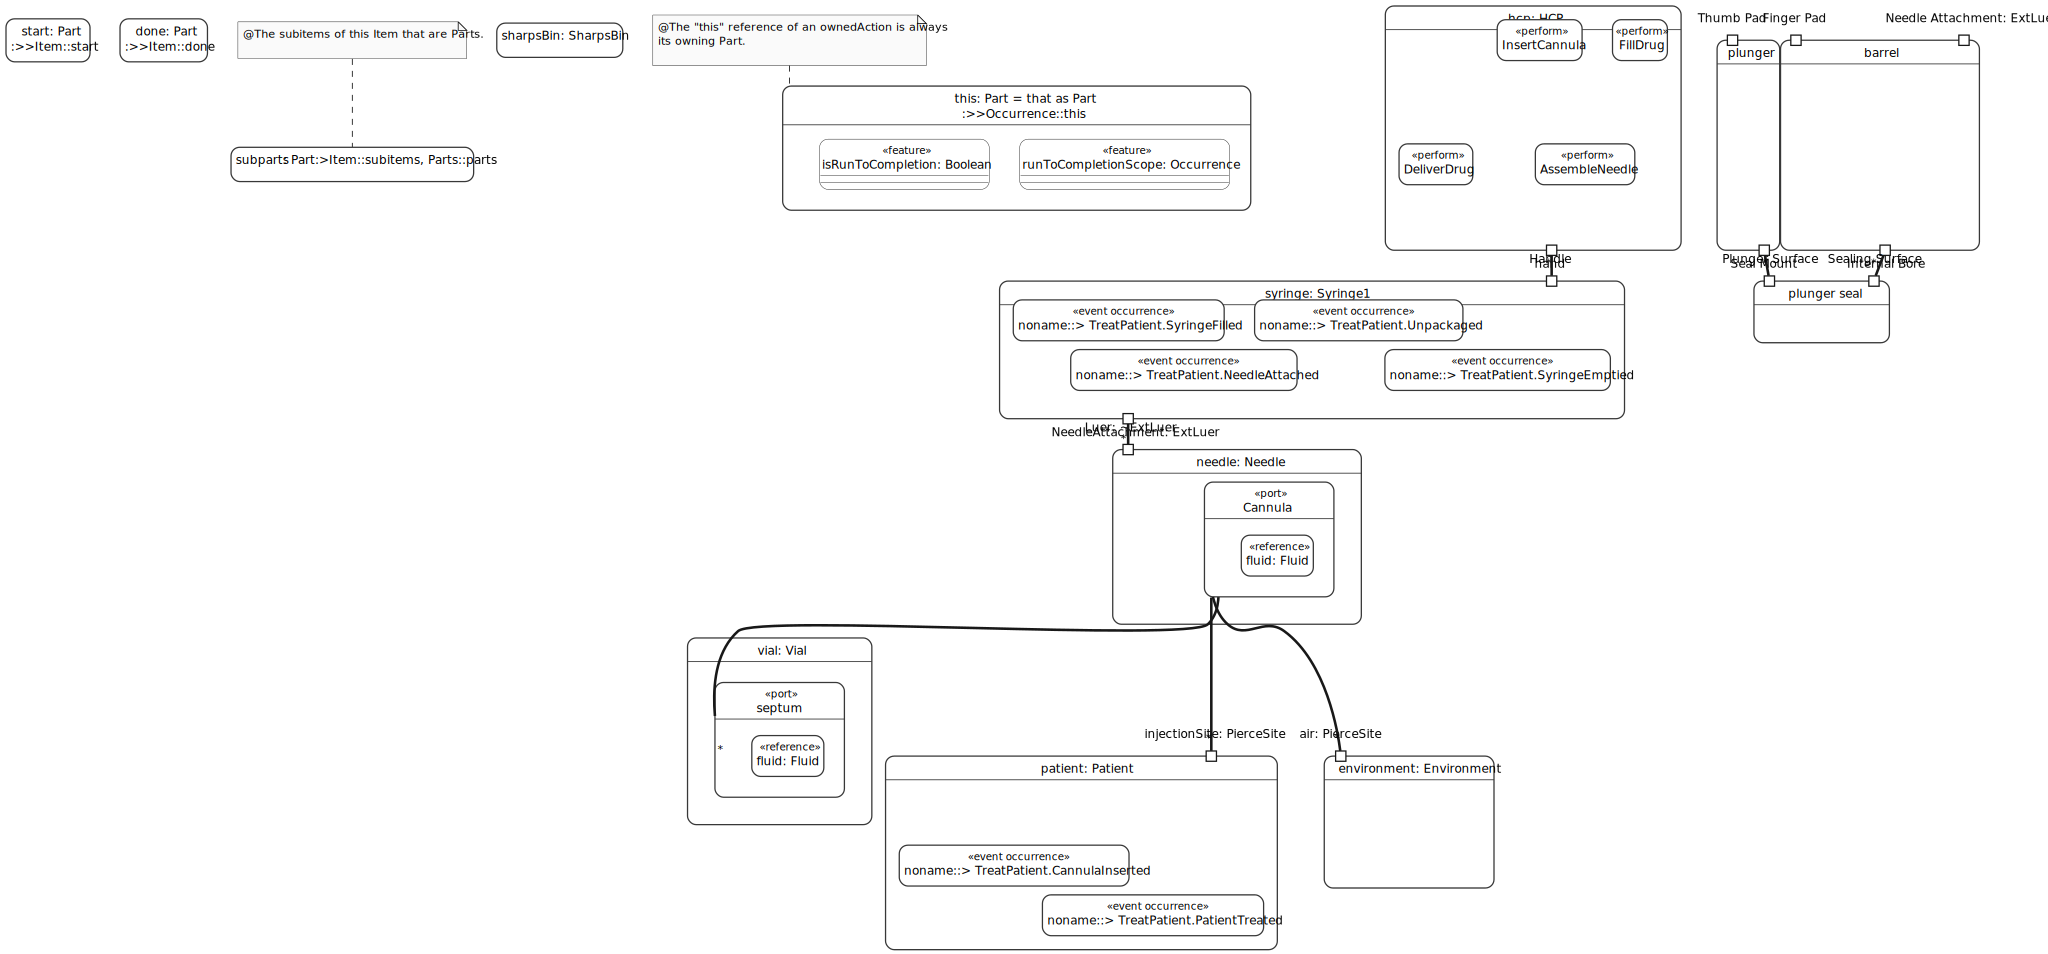

In [3]:
%view "SyringeSystem::ViewDefs::TreatmentContextView"

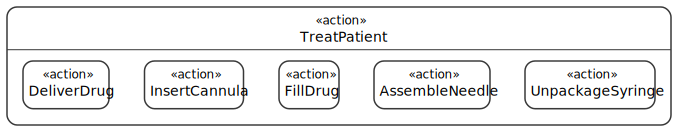

In [5]:
%viz --view=action "SyringeSystem::Library::ActionDefs::TreatPatient"

In [108]:
package SyringeModel{
    package Library{
        part def Syringe{
            port Handle;
            port NeedleAttachment;
        }
        interface def PiercingInterface{
            end pierceSite : PierceSite;
            end cannula: Cannula;
        }
        port def Cannula;
        port def PierceSite;
        part def Environment{
            port air : PierceSite;
        }
    }
    package Structure{
        import Library::*;
        part def Syringe1 :> Syringe{
            part plunger{
                port 'Seal Mount';
                port 'Thumb Pad';
            }
            part barrel{
                port 'Finger Pad';
                port 'Internal Bore';
                port 'Needle Attachment';
            }
            part 'plunger seal'{
                port 'Plunger Surface';
                port 'Sealing Surface';
            }
            bind barrel.'Needle Attachment' = NeedleAttachment;
            bind barrel.'Finger Pad' = Handle;
            bind plunger.'Thumb Pad' = Handle;
            connect plunger.'Seal Mount' to 'plunger seal'.'Plunger Surface';
            connect barrel.'Internal Bore' to 'plunger seal'.'Sealing Surface';
        }
    }
    package Context{
        import Structure::*;
        import Library::*;
        part Hospital{
            part hcp{
                port hand;
            }
            part environment:Environment;
            part syringe:Syringe1;
            timeslice Storage = start;
            then timeslice InUse{
                part needle{
                    port luer;
                    port cannula:Cannula;
                }
                part vial{
                    port septum:PierceSite;
                }
                part patient{
                    port injectionSite:PierceSite;
                }
                connect needle.luer to syringe.NeedleAttachment;
                connect hcp.hand to syringe.Handle;
                interface needleConnection : PiercingInterface connect
                    cannula ::>needle.cannula to 
                    pierceSite ::> environment.air;  
                timeslice Filling = start{
                    interface redefines needleConnection connect
                        cannula ::>needle.cannula to 
                        pierceSite ::> vial.septum;    
                }
                then timeslice Delivering{
                    interface redefines needleConnection connect
                        cannula ::>needle.cannula to 
                        pierceSite ::> patient.injectionSite;
                }
            }
            then timeslice Disposed{
                part sharpsBin;
            }
        }
    }
    package ViewDefs{
        import Views::*;
        import Context::*;
        view TreatmentContextView {
            expose Hospital::InUse::Delivering::**[@SysML::PartUsage and not (@SysML::EventOccurrenceUsage)];
            render asInterconnectionDiagram;
        }
    }
}

Package SyringeModel (027b50fa-a0d0-4784-92e7-ee00ad0c7b2a)


In [49]:
package 'Local Clock Example' {
	import ScalarValues::String;
    import SI::*;
	
	item def Start;
	item def Request;
	
	part def Server {
		part :>> localClock = Time::Clock();

		attribute today : String;
				
		port requestPort;
		
		state ServerBehavior {
			entry; then off;
			
			state off;
			accept Start via requestPort
				then waiting;
			
			state waiting;
			accept request : Request via requestPort
				then responding;
			accept at Time::Iso8601DateTime(today + "11:59:00")
				then off;
			
			state responding;
			accept after 5 [min]
				then waiting;
		}
	}
}

Package Local Clock Example (b8b655ec-7971-42af-84f6-de21005c43d5)
